In [25]:
import an_1
a =  an_1.An("/Users/fengzhang/PycharmProjects/inboom_cta/ml_cta/7")

In [26]:
df1 = a.test_PnL/5000000

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
def calculate_risk_contribution(w, cov_matrix):
    """计算各资产的风险贡献"""
    port_vol = np.sqrt(w.T @ cov_matrix @ w)
    marginal_contrib = (cov_matrix @ w) / port_vol
    risk_contrib = w * marginal_contrib
    return risk_contrib / risk_contrib.sum()  # 归一化


def risk_parity_objective(w, cov_matrix):
    """优化目标：风险贡献的方差最小化"""
    rc = calculate_risk_contribution(w, cov_matrix)
    target_rc = np.ones_like(w) / len(w)  # 目标风险贡献相等
    return np.sum((rc - target_rc) ** 2)


def rolling_risk_parity(returns, window=120, rebalance_freq='M'):
    """修正后的滚动风险平价函数"""
    # 生成再平衡日期并过滤不存在于原始数据的日期
    reb_dates = returns.resample(rebalance_freq).last().index
    reb_dates = reb_dates[reb_dates.isin(returns.index)]

    weights = pd.DataFrame(index=reb_dates, columns=returns.columns)

    for i, date in enumerate(reb_dates):
        # 获取日期在原始数据中的位置
        date_pos = returns.index.get_loc(date)

        # 计算窗口起始位置，防止越界
        start_pos = max(0, date_pos - window)
        start_date = returns.index[start_pos]

        # 提取窗口数据（使用iloc避免KeyError）
        window_returns = returns.iloc[start_pos:date_pos]

        # 检查窗口数据长度
        if len(window_returns) < 10:  # 最小数据量要求
            weights.loc[date] = np.nan
            continue

        # 计算协方差矩阵
        from sklearn.covariance import LedoitWolf
        cov_matrix = LedoitWolf().fit(window_returns).covariance_
        #cov_matrix = window_returns.cov().values

        # 优化权重（逻辑保持不变）
        n_assets = len(returns.columns)
        initial_guess = np.ones(n_assets) / n_assets

        constraints = (
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda w: w}
        )

        result = minimize(
            risk_parity_objective,
            initial_guess,
            args=(cov_matrix,),
            method='SLSQP',
            constraints=constraints,
            tol=1e-6
        )

        if result.success:
            weights.loc[date] = result.x
        else:
            weights.loc[date] = np.nan

    # 前向填充权重
    weights = weights.resample('D').ffill().reindex(returns.index)
    return weights.dropna(how='all')
# =========================================================================
# 3. 执行滚动风险平价
# =========================================================================
# 参数设置
window_length = 120  # 6个月（假设每月20个交易日）
rebalance_freq = 'M'  # 每月再平衡

In [28]:
weights = rolling_risk_parity(df1, window=window_length, rebalance_freq=rebalance_freq)


/var/folders/qt/hlt4_qzs3978jyjs74n7319h0000gn/T/ipykernel_33656/340753556.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  reb_dates = returns.resample(rebalance_freq).last().index


In [29]:
weights

strategy,1,2,3,4,5
trade_day,,,,,
2017-02-28,0.332242,0.165524,0.162537,0.167086,0.172612
2017-03-01,0.332242,0.165524,0.162537,0.167086,0.172612
2017-03-02,0.332242,0.165524,0.162537,0.167086,0.172612
2017-03-03,0.332242,0.165524,0.162537,0.167086,0.172612
2017-03-06,0.332242,0.165524,0.162537,0.167086,0.172612
...,...,...,...,...,...
2024-12-25,0.298316,0.169629,0.131108,0.194832,0.206116
2024-12-26,0.298316,0.169629,0.131108,0.194832,0.206116
2024-12-27,0.298316,0.169629,0.131108,0.194832,0.206116


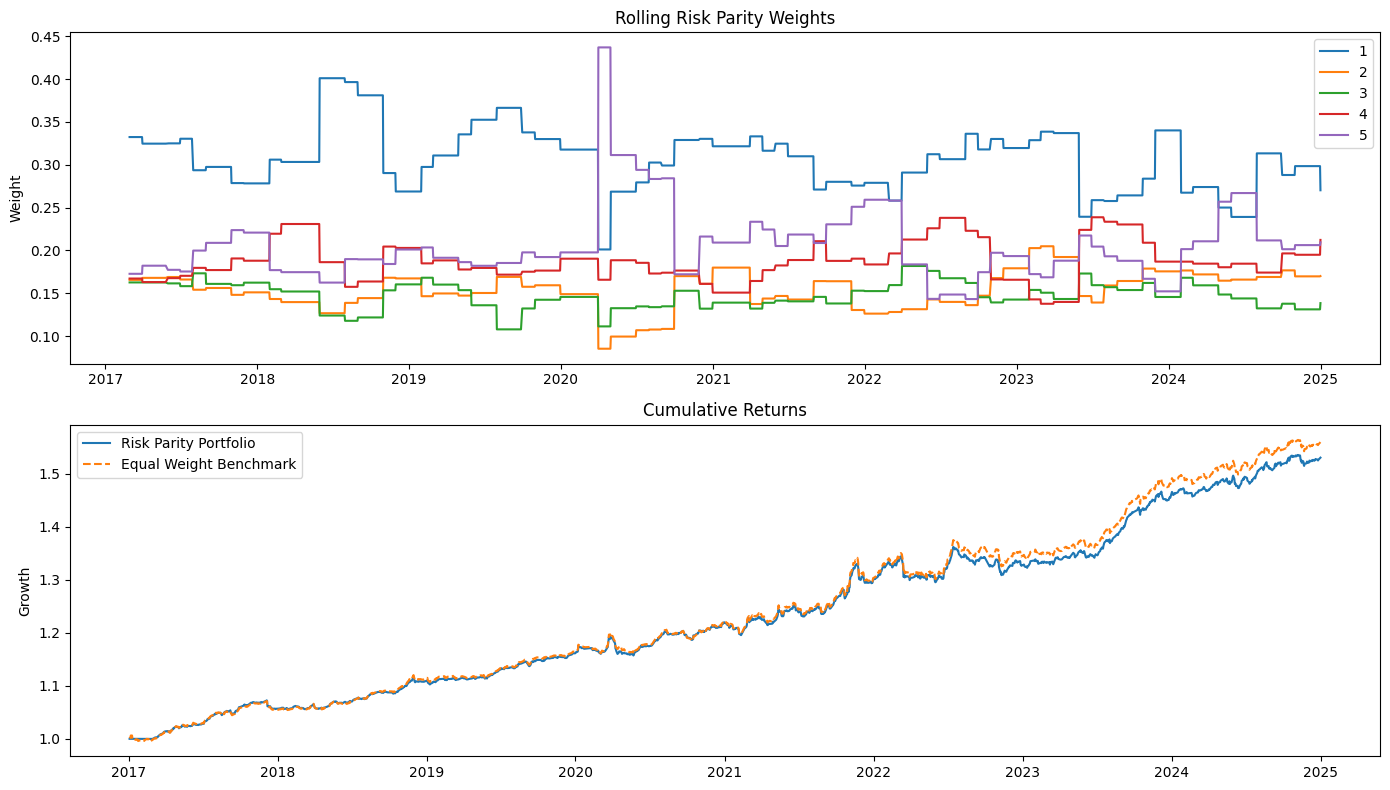


策略绩效对比:


,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio
Risk Parity,0.055776,0.028312,1.970028,-0.039134,1.425256
Equal Weight,0.058298,0.030202,1.930271,-0.036290,1.606455


In [30]:
portfolio_returns = (df1 * weights.shift(1)).sum(axis=1)  # 次日调仓

# 可视化
plt.figure(figsize=(14, 8))

# 绘制权重变化
plt.subplot(2, 1, 1)
for col in weights.columns:
    plt.plot(weights.index, weights[col], label=col)
plt.title('Rolling Risk Parity Weights')
plt.ylabel('Weight')
plt.legend()

# 绘制累计收益
plt.subplot(2, 1, 2)
cumulative_port = (1 + portfolio_returns).cumprod()
cumulative_bm = (1 + df1.mean(axis=1)).cumprod()  # 等权重作为基准
plt.plot(cumulative_port, label='Risk Parity Portfolio')
plt.plot(cumulative_bm, label='Equal Weight Benchmark', linestyle='--')
plt.title('Cumulative Returns')
plt.ylabel('Growth')
plt.legend()

plt.tight_layout()
plt.show()


# =========================================================================
# 5. 关键指标输出
# =========================================================================
def calculate_metrics(returns):
    """计算绩效指标"""
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - peak) / peak

    return pd.Series({
        'Annualized Return': returns.mean() * 252,
        'Annualized Volatility': returns.std() * np.sqrt(252),
        'Sharpe Ratio': returns.mean() / returns.std() * np.sqrt(252),
        'Max Drawdown': drawdown.min(),
        'Calmar Ratio': returns.mean() * 252 / abs(drawdown.min())
    })


port_metrics = calculate_metrics(portfolio_returns)
bm_metrics = calculate_metrics(df1.mean(axis=1))

print("\n策略绩效对比:")
pd.concat([port_metrics.rename('Risk Parity'),
           bm_metrics.rename('Equal Weight')], axis=1).T